In [ ]:
# Google Drive
!gdown --id '1OqmmCIz1uwbj5RNkjpN_9Fnk6rdjJRES' --output fashion.zip

# Unzip the dataset.
# This may take some time.
!unzip -q fashion.zip


Downloading...
From: https://drive.google.com/uc?id=1OqmmCIz1uwbj5RNkjpN_9Fnk6rdjJRES
To: /content/fashion.zip
72.1MB [00:01, 70.9MB/s]


In [ ]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.models as model
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import Dataset, ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

import pandas as pd
import torch.hub
from typing import Any

# This is for the progress bar.
from tqdm.auto import tqdm

## 原始模型表現


In [ ]:

train_csv = pd.read_csv("fashion-mnist_train.csv")
test_csv = pd.read_csv("fashion-mnist_test.csv")

In [ ]:
train_csv.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [ ]:
class FashionDataset(Dataset):
  def __init__(self, data, transform = None):
    """Method to initilaize variables.""" 
    self.fashion_MNIST = list(data.values)
    self.transform = transform
    
    label = []
    image = []
    
    for i in self.fashion_MNIST:
      label.append(i[0])
      image.append(i[1:])
    self.labels = np.asarray(label)
    print(self.labels)
    self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

  def __getitem__(self, index):
    label = self.labels[index]
    image = self.images[index]
    
    if self.transform is not None:
      image = self.transform(image)

    return image, label

  def __len__(self):
    return len(self.images)

In [ ]:
batch_size = 100
train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=8, pin_memory=True)
test_loader = DataLoader(train_set, batch_size=batch_size, num_workers=8, pin_memory=True)

[2 9 6 ... 8 8 7]
[0 1 2 ... 8 8 1]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def output_label(label):
  output_mapping = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
    }
  input = (label.item() if type(label) == torch.Tensor else label)
  return output_mapping[input]

2


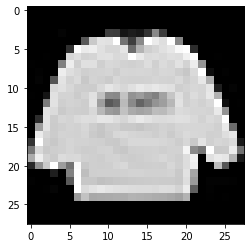

In [ ]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [ ]:
class AlexNet(nn.Module):
  def __init__(self, num_classes):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
    self.classifier = nn.Sequential(
      nn.Dropout(),
      nn.Linear(256 * 3 * 3, 1024),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(1024, 512),
      nn.ReLU(inplace=True),
      nn.Linear(512, num_classes),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x


In [ ]:
nn.Linear(512, 10).weight

Parameter containing:
tensor([[-0.0365, -0.0129,  0.0371,  ..., -0.0060, -0.0230,  0.0264],
        [ 0.0105, -0.0341,  0.0229,  ..., -0.0431,  0.0068,  0.0127],
        [-0.0403, -0.0291,  0.0144,  ...,  0.0079, -0.0034, -0.0221],
        ...,
        [ 0.0002,  0.0207, -0.0106,  ...,  0.0053, -0.0351, -0.0268],
        [ 0.0155, -0.0439, -0.0008,  ..., -0.0405, -0.0362,  0.0186],
        [ 0.0180, -0.0222,  0.0242,  ...,  0.0439,  0.0285,  0.0228]],
       requires_grad=True)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AlexNet(num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (x,y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if batch%100==0:
    loss, current = loss.item(), batch * len(x)
    print(f"loss: {loss: >7f}[{curret: >5d}/{size: >5d}]")

def _test(dataloader, model):
  size = len(dataloader.dataset)
  model.eval()
  test_loss, correct = 0,0
  with torch.no_grad():
    for x, y in dataloader:
      x, y = x.to(device), y.to(device)
      pred = model(x)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1)==y).type(torch.float).sum().item()
  test_loss /= size
  correct /= size
  print(f"Test error: \n Acc: {correct}, Avg Loss:{test_loss}")

epoch = 5
for t in range(epoch):
  print(f"Epoch {t+1}\n-----------------")
  train(train_loader, model, loss_fn, optimizer)
  _test(test_loader, model)

Epoch 1
-----------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test error: 
 Acc: 0.7280333333333333, Avg Loss:0.007594069035847982
Epoch 2
-----------------
Test error: 
 Acc: 0.7930333333333334, Avg Loss:0.00575895200073719
Epoch 3
-----------------
Test error: 
 Acc: 0.82915, Avg Loss:0.0048978009685873986
Epoch 4
-----------------
Test error: 
 Acc: 0.8479833333333333, Avg Loss:0.004352654937158028
Epoch 5
-----------------
Test error: 
 Acc: 0.86055, Avg Loss:0.003996558294693629


In [ ]:
for par in model.parameters():
  print(par)
  print(len(par))

Parameter containing:
tensor([[[[ 0.2055, -0.2132, -0.1550],
          [ 0.1608, -0.1092, -0.1976],
          [-0.0179, -0.1101, -0.0109]]],


        [[[ 0.1945,  0.1182, -0.2940],
          [-0.2536, -0.0288,  0.2353],
          [ 0.3132,  0.0530,  0.1770]]],


        [[[-0.1933, -0.2681,  0.3056],
          [ 0.0044, -0.0577, -0.1703],
          [-0.1628,  0.2350, -0.2227]]],


        [[[-0.2800,  0.3247, -0.2628],
          [-0.2807,  0.1655,  0.2105],
          [-0.2288, -0.0941, -0.1436]]],


        [[[-0.1959, -0.1268, -0.3256],
          [ 0.2928, -0.2566,  0.1442],
          [ 0.0353, -0.1397,  0.0158]]],


        [[[-0.0815, -0.1822,  0.2802],
          [-0.1386,  0.0075,  0.1862],
          [-0.2207,  0.1834, -0.2657]]],


        [[[-0.3254, -0.1510, -0.1264],
          [ 0.2009,  0.3057,  0.2362],
          [ 0.3195,  0.1984, -0.2392]]],


        [[[ 0.0897, -0.0905,  0.3261],
          [ 0.1256, -0.2986,  0.0853],
          [-0.3006, -0.2460, -0.2241]]],


        [[

## 目標malware執行檔

In [ ]:
malware = pd.read_csv("malFloat.csv")
malware = malware.drop(columns = 'Unnamed: 0')
malware.head()

,0
0,0.012534
1,0.007813
2,0.007813
3,0.007812
4,0.031250


In [ ]:
malFloat = malware['0'].tolist()
print(len(malFloat))

35459


In [ ]:
weight_matrix = torch.tensor([malFloat[:512]], dtype=torch.float32)
print(weight_matrix)

tensor([[0.0125, 0.0078, 0.0078, 0.0078, 0.0312, 0.0079, 0.0078, 0.0078, 0.0117,
         0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078,
         0.0078, 0.0078, 0.0283, 0.0078, 0.0227, 0.0220, 0.0099, 0.0125, 0.0130,
         0.0148, 0.0148, 0.0148, 0.0098, 0.0146, 0.0149, 0.0140, 0.0150, 0.0142,
         0.0120, 0.0098, 0.0139, 0.0086, 0.0100, 0.0078, 0.0078, 0.0114, 0.0282,
         0.0101, 0.0087, 0.0134, 0.0149, 0.0101, 0.0087, 0.0242, 0.0242, 0.0101,
         0.0200, 0.0134, 0.0309, 0.0101, 0.0087, 0.0100, 0.0276, 0.0101, 0.0087,
         0.0134, 0.0309, 0.0101, 0.0087, 0.0242, 0.0281, 0.0101, 0.0180, 0.0134,
         0.0128, 0.0142, 0.0087, 0.0078, 0.0078, 0.0078, 0.0078, 0.0164, 0.0155,
         0.0134, 0.0078, 0.0078, 0.0293, 0.0078, 0.0084, 0.0288, 0.0079, 0.0078,
         0.0078, 0.0111, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078,
         0.0078, 0.0078, 0.0078, 0.0079, 0.0078, 0.0078, 0.0078, 0.0078, 0.0162,
         0.0080, 0.0157, 0.0

## 將parameter換成malware

In [ ]:
class AlexNet(nn.Module):
  def __init__(self, num_classes):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
    nn.Linear(512, num_classes).weight = nn.Parameter(weight_matrix)
    self.classifier = nn.Sequential(
      nn.Dropout(),
      nn.Linear(256 * 3 * 3, 1024),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(1024, 512),
      nn.ReLU(inplace=True),
      nn.Linear(512, num_classes),
      
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [ ]:
nn.Linear(1024, 512).weight

Parameter containing:
tensor([[-0.0123,  0.0263, -0.0226,  ...,  0.0269,  0.0063,  0.0175],
        [-0.0049, -0.0250, -0.0092,  ...,  0.0218,  0.0187,  0.0222],
        [ 0.0065,  0.0130,  0.0200,  ...,  0.0055, -0.0153, -0.0257],
        ...,
        [-0.0062, -0.0181, -0.0270,  ...,  0.0164,  0.0096,  0.0227],
        [-0.0237, -0.0091, -0.0051,  ...,  0.0273, -0.0119, -0.0161],
        [-0.0202,  0.0117, -0.0012,  ...,  0.0069,  0.0117, -0.0129]],
       requires_grad=True)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AlexNet(num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (x,y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if batch%100==0:
    loss, current = loss.item(), batch * len(x)
    print(f"loss: {loss: >7f}[{curret: >5d}/{size: >5d}]")

def _test(dataloader, model):
  size = len(dataloader.dataset)
  model.eval()
  test_loss, correct = 0,0
  with torch.no_grad():
    for x, y in dataloader:
      x, y = x.to(device), y.to(device)
      pred = model(x)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1)==y).type(torch.float).sum().item()
  test_loss /= size
  correct /= size
  print(f"Test error: \n Acc: {correct}, Avg Loss:{test_loss}")

epoch = 5
for t in range(epoch):
  print(f"Epoch {t+1}\n-----------------")
  train(train_loader, model, loss_fn, optimizer)
  _test(test_loader, model)

Epoch 1
-----------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test error: 
 Acc: 0.71135, Avg Loss:0.007520571096738179
Epoch 2
-----------------
Test error: 
 Acc: 0.81275, Avg Loss:0.005302051740388076
Epoch 3
-----------------
Test error: 
 Acc: 0.8392333333333334, Avg Loss:0.004604297307133675
Epoch 4
-----------------
Test error: 
 Acc: 0.8541833333333333, Avg Loss:0.004170298538108666
Epoch 5
-----------------
Test error: 
 Acc: 0.8631166666666666, Avg Loss:0.0038730158237119516


In [ ]:
nn.Linear(1024, 512).weight

Parameter containing:
tensor([[-0.0111,  0.0274, -0.0309,  ..., -0.0149,  0.0040,  0.0125],
        [ 0.0309, -0.0258,  0.0127,  ...,  0.0188,  0.0123, -0.0168],
        [ 0.0164,  0.0029,  0.0057,  ..., -0.0035,  0.0170, -0.0106],
        ...,
        [ 0.0133,  0.0293,  0.0298,  ...,  0.0230,  0.0037, -0.0116],
        [-0.0139,  0.0048,  0.0130,  ..., -0.0139, -0.0203, -0.0111],
        [-0.0306, -0.0030,  0.0108,  ...,  0.0102, -0.0106,  0.0099]],
       requires_grad=True)

In [ ]:
weight_matrix

tensor([[0.0125, 0.0078, 0.0078, 0.0078, 0.0312, 0.0079, 0.0078, 0.0078, 0.0117,
         0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078,
         0.0078, 0.0078, 0.0283, 0.0078, 0.0227, 0.0220, 0.0099, 0.0125, 0.0130,
         0.0148, 0.0148, 0.0148, 0.0098, 0.0146, 0.0149, 0.0140, 0.0150, 0.0142,
         0.0120, 0.0098, 0.0139, 0.0086, 0.0100, 0.0078, 0.0078, 0.0114, 0.0282,
         0.0101, 0.0087, 0.0134, 0.0149, 0.0101, 0.0087, 0.0242, 0.0242, 0.0101,
         0.0200, 0.0134, 0.0309, 0.0101, 0.0087, 0.0100, 0.0276, 0.0101, 0.0087,
         0.0134, 0.0309, 0.0101, 0.0087, 0.0242, 0.0281, 0.0101, 0.0180, 0.0134,
         0.0128, 0.0142, 0.0087, 0.0078, 0.0078, 0.0078, 0.0078, 0.0164, 0.0155,
         0.0134, 0.0078, 0.0078, 0.0293, 0.0078, 0.0084, 0.0288, 0.0079, 0.0078,
         0.0078, 0.0111, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078,
         0.0078, 0.0078, 0.0078, 0.0079, 0.0078, 0.0078, 0.0078, 0.0078, 0.0162,
         0.0080, 0.0157, 0.0

In [ ]:
nn.Linear(1024, 512).weight = nn.Parameter(weight_matrix)
nn.Linear(1024, 512).weight

Parameter containing:
tensor([[-0.0093, -0.0292,  0.0052,  ..., -0.0253,  0.0208, -0.0310],
        [-0.0028, -0.0043, -0.0052,  ..., -0.0280,  0.0201,  0.0175],
        [-0.0264,  0.0298,  0.0048,  ..., -0.0017, -0.0052, -0.0233],
        ...,
        [ 0.0006,  0.0117,  0.0071,  ..., -0.0151, -0.0241, -0.0125],
        [ 0.0085, -0.0116, -0.0174,  ...,  0.0036, -0.0292, -0.0217],
        [-0.0285, -0.0301,  0.0296,  ..., -0.0263, -0.0231, -0.0204]],
       requires_grad=True)

**Reference**\
https://blog.csdn.net/qq_45465526/article/details/115918610